<style>
    .center-text{
        text-align: center;
    }
</style>

<div class='center-text'>

# Proyecto Aprendizaje Automático

## Reconocimiento de caracteres alfanuméricos escritos a mano

### Julian Ricardo Salazar duarte

#### Universidad Nacional de Colombia

#### 2024-1
</div>

### 0. Configuración de entorno

In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'english-handwritten-characters-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1176843%2F1972672%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240927%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240927T133603Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcc8040f82665c53236f5d9582015b5739e7b206e2089eb5dec3c45d7d2cfe9f7826fe29da07cfa9752ac4bae2ffd2878ee9ad9da3043419f8de278a78b0491c3d54c3141e46bd80195452f0cd5f8ee353d5a677d85086433145a4c3c0fd2ca4f0fb9b07bcd101670c391c5a0cd5ae2298fc49f582a776790f4cd1efcf25e6b60448de07de327eeb677be4fdb1210fa24a5ebb1d4a7dbed9dabcc180a49a8a7539a0f8ed087bbb18233033b7a53a7cae6fe6f2464cdb7e954a2d1ef98e56e178643a444893e1c0aeec860aa8933ea4da666be530c730cd265330af6767a11b754c5b7c3faf323eccb20dcf5977b03141ca6b357c44147df6d5b06a1574a6a4902'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13694607 bytes downloaded
Downloaded and uncompressed: english-handwritten-characters-dataset
Data source import complete.


In [11]:
%pip install mlflow optuna

In [12]:
import os
import random
import optuna
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from multiprocessing import Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import seaborn as sns


<a id="s1"></a>
## 1. Análisis exploratorio de datos

In [ ]:
# data path
data_dir = '/kaggle/input/english-handwritten-characters-dataset/english.csv'
img_dir = '/kaggle/input/english-handwritten-characters-dataset/'

In [ ]:
# load data
data = pd.read_csv(data_dir)

X_path = data['image']
y = data['label']

X_path = [os.path.join(img_dir, path) for path in X_path]


In [ ]:
# dataset information
print(data.head())

print(f"\nNúmero de ejemplos: {len(data)}")
print(f"\nClases únicas: {data['label'].unique()}")

                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0

Número de ejemplos: 3410

Clases únicas: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


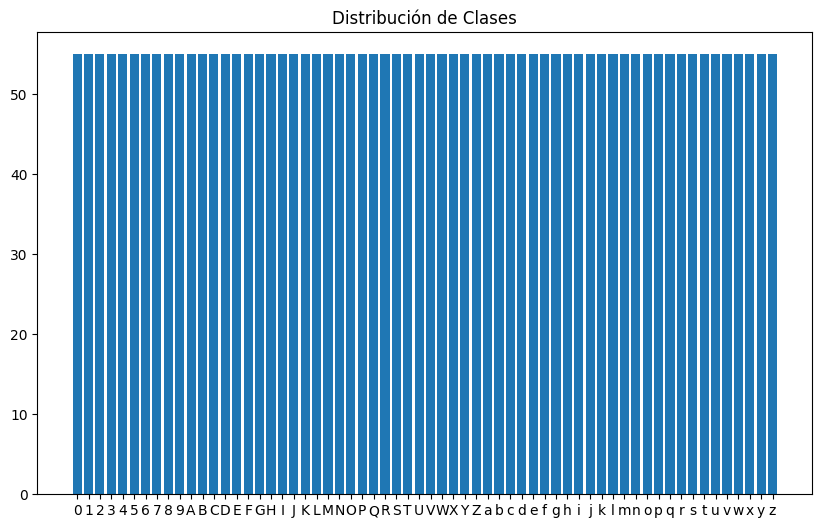

In [ ]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(Counter(y).keys(), Counter(y).values())
plt.title("Distribución de Clases")
plt.show()

In [ ]:
# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Convertir Y_train y Y_test a etiquetas numéricas
y = label_encoder.fit_transform(y)

In [ ]:
y_dict = {}
for i in range(10):
    y_dict[i] = i

for i in range(26):
    y_dict[i+10] = chr(i+65)

for i in range(26):
    y_dict[i+36] = chr(i+97)

In [ ]:
pixel_values = []
for path in X_path[:10]:  # Analizar las primeras 10 imágenes
    img = plt.imread(path)
    pixel_values.extend(img.flatten())

print(f"Valor mínimo de píxel: {min(pixel_values)}")
print(f"Valor máximo de píxel: {max(pixel_values)}")
print(f"Valor promedio de píxel: {np.mean(pixel_values)}")

Valor mínimo de píxel: 0.0
Valor máximo de píxel: 1.0
Valor promedio de píxel: 0.9343602657318115


In [ ]:
# Función para redimensionar y normalizar
def resize_and_normalize(image_path, target_size=(64, 64)):
    try:
        img = load_img(image_path, target_size=target_size, color_mode='grayscale')
        return img_to_array(img) / 255.0

    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")
        return None

# Procesamiento paralelo
def process_images(X_path, target_size):
    with Pool() as pool:
        X_processed = pool.starmap(resize_and_normalize, [(path, target_size) for path in X_path])
    return np.array([img for img in X_processed if img is not None])

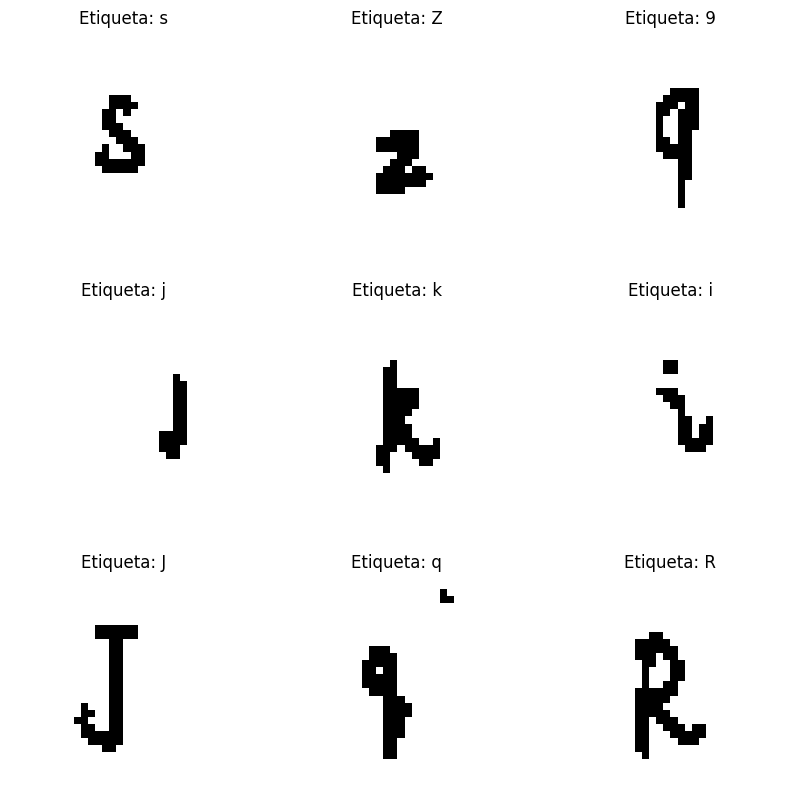

In [ ]:
target_size = (32, 32)
X_processed = process_images(X_path, target_size)

# Visualización de algunas imágenes procesadas
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    idx = random.randint(0, len(X_path) - 1)
    plt.imshow(X_processed[idx], cmap='gray')
    plt.title(f"Etiqueta: {y_dict[y[idx]]}")
    plt.axis('off')
plt.show()

Forma del array de imágenes procesadas: (3410, 32, 32, 1)
Valor mínimo: 0.0
Valor máximo: 1.0


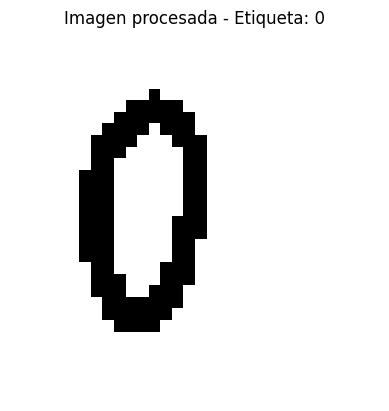

In [ ]:
print("Forma del array de imágenes procesadas:", X_processed.shape)
print("Valor mínimo:", X_processed.min())
print("Valor máximo:", X_processed.max())

plt.imshow(X_processed[0], cmap='gray')
plt.title(f"Imagen procesada - Etiqueta: {y[0]}")
plt.axis('off')
plt.show()

In [ ]:
# aumento de datos
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotación aleatoria en el rango de +/- 15 grados
    zoom_range=0.1,     # Zoom aleatorio de hasta +/- 10%
    width_shift_range=0.1,  # Desplazamiento horizontal de hasta +/- 10%
    height_shift_range=0.1, # Desplazamiento vertical de hasta +/- 10%
    fill_mode='nearest',     # Método para rellenar píxeles nuevos
)

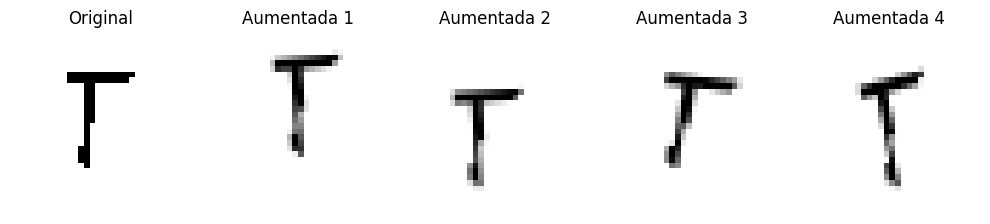

In [ ]:
def plot_augmented_images(original_image, num_augmented=4):
    plt.figure(figsize=(10, 10))

    # Mostrar la imagen original
    plt.subplot(1, num_augmented + 1, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Generar y mostrar imágenes aumentadas
    for i in range(num_augmented):
        augmented = datagen.random_transform(original_image)
        plt.subplot(1, num_augmented + 1, i + 2)
        plt.imshow(augmented, cmap='gray')
        plt.title(f'Aumentada {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_augmented_images(X_processed[random.randint(0, len(X_processed) - 1)])

In [ ]:
def augment_data(X, y, num_augmented_per_image=5):
    X_augmented = []
    y_augmented = []

    for image, label in zip(X, y):
        X_augmented.append(image)
        y_augmented.append(label)

        for _ in range(num_augmented_per_image):
            aug_image = datagen.random_transform(image)
            X_augmented.append(aug_image)
            y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

# Aplicar la aumentación
X_aug, y_aug = augment_data(X_processed, y, num_augmented_per_image=5)

print("Forma original del conjunto de datos:", X_processed.shape)
print("Forma del conjunto de datos aumentado:", X_aug.shape)

Forma original del conjunto de datos: (3410, 32, 32, 1)
Forma del conjunto de datos aumentado: (20460, 32, 32, 1)


In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.2):
    # Primero, separamos el conjunto de prueba
    X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                      test_size=test_size,
                                                      stratify=y,
                                                      random_state=42)

    # Luego, del resto, separamos el conjunto de validación
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                      test_size=val_size_adjusted,
                                                      stratify=y_temp,
                                                      random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

# separar los datos
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_aug, y_aug)

# Imprimir las formas de los conjuntos resultantes
print("Formas de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Validación: {X_val.shape}, {y_val.shape}")
print(f"Prueba: {X_test.shape}, {y_test.shape}")

# Verificar la distribución de clases en cada conjunto
def check_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

Formas de los conjuntos de datos:
Entrenamiento: (12276, 32, 32, 1), (12276,)
Validación: (4092, 32, 32, 1), (4092,)
Prueba: (4092, 32, 32, 1), (4092,)


<a id="s2"></a>
## 2. Modelos de Machine Learning

#### 2.0 configurción de experimentos

In [ ]:
# configuracón de experimentos
mlflow.set_experiment("handwritten recognition")

<Experiment: artifact_location='file:///content/mlruns/681922117407597071', creation_time=1726089556809, experiment_id='681922117407597071', last_update_time=1726089556809, lifecycle_stage='active', name='handwritten recognition', tags={}>

In [ ]:
# Aplanar las imágenes para SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Forma de los datos aplanados:", X_train_flat.shape)

Forma de los datos aplanados: (12276, 1024)


In [ ]:
# registrar modelo en mlflow
def register_model(model, model_name, metrics, images_path = None, sk=True):
    with mlflow.start_run():
        mlflow.log_params(model.get_params())
        if sk:
            mlflow.sklearn.log_model(model, model_name)
        else:
            mlflow.xgboost.log_model(model, model_name)
        if images_path is not None:
            for img in images_path:
                mlflow.log_artifact(img)
                os.remove(img)

        mlflow.log_metrics(metrics)

In [ ]:
def top_5_models(study, params_list):
    print("\nLos 5 mejores modelos:")
    best_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]

    data = {
        'Rank': range(1, 6),
        'Score': [trial.value for trial in best_trials]
    }

    for param in params_list:
        data[param] = [trial.params.get(param, None) for trial in best_trials]

    best_models_df = pd.DataFrame(data)
    print(best_models_df.to_string(index=False))

In [ ]:
def worst_5_models(study, params_list):
    print("\nLos 5 peores modelos:")
    worst_trials = sorted(study.trials, key=lambda t: t.value)[:5]

    data = {
        'Rank': range(1, 6),
        'Score': [trial.value for trial in worst_trials]
    }

    for param in params_list:
        data[param] = [trial.params.get(param, None) for trial in worst_trials]

    worst_models_df = pd.DataFrame(data)
    print(worst_models_df.to_string(index=False))

#### 2.1 support vector machine (SVM)

##### I. Modelo base

In [ ]:
metrics = {} # diccionario para almacenar el accuracy de train , val y test

In [ ]:
# Entrenamiento inicial del modelo
svm = SVC()

svm.fit(X_train_flat, y_train)

SVC()

In [ ]:
# datos de entrenamiento
y_train_pred = svm.predict(X_train_flat)
metrics['train accuracy'] = accuracy_score(y_train, y_train_pred)
print("Accuracy en entrenameinto:", metrics['train accuracy'])
print(classification_report(y_train, y_train_pred))

Accuracy en entrenameinto: 0.7132616487455197
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       198
           1       0.41      0.59      0.48       198
           2       0.83      0.72      0.77       198
           3       0.80      0.79      0.79       198
           4       0.61      0.62      0.61       198
           5       0.91      0.69      0.78       198
           6       0.92      0.68      0.78       198
           7       0.47      0.73      0.57       198
           8       0.71      0.77      0.74       198
           9       0.45      0.75      0.56       198
          10       0.84      0.82      0.83       198
          11       0.89      0.79      0.84       198
          12       0.84      0.85      0.84       198
          13       0.87      0.82      0.85       198
          14       0.95      0.79      0.86       198
          15       0.88      0.79      0.84       198
          16       0.93      0.86  

In [ ]:
# Validacíon
y_val_pred = svm.predict(X_val_flat)
metrics['val accuracy'] = accuracy_score(y_val, y_val_pred)
print("Accuracy en validación:", metrics['val accuracy'])
print(classification_report(y_val, y_val_pred))

Accuracy en validación: 0.4418377321603128
              precision    recall  f1-score   support

           0       0.29      0.33      0.31        66
           1       0.30      0.52      0.38        66
           2       0.55      0.53      0.54        66
           3       0.48      0.45      0.47        66
           4       0.38      0.30      0.34        66
           5       0.72      0.39      0.51        66
           6       0.71      0.48      0.58        66
           7       0.26      0.44      0.33        66
           8       0.35      0.56      0.43        66
           9       0.22      0.38      0.27        66
          10       0.53      0.44      0.48        66
          11       0.50      0.39      0.44        66
          12       0.68      0.68      0.68        66
          13       0.52      0.53      0.53        66
          14       0.70      0.50      0.58        66
          15       0.56      0.41      0.47        66
          16       0.59      0.56     

In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred = svm.predict(X_test_flat)
metrics['test accuracy'] = accuracy_score(y_test, y_test_pred)
print("Accuracy en prueba:", metrics['test accuracy'])
print(classification_report(y_test, y_test_pred))

Accuracy en prueba: 0.4423264907135875
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        66
           1       0.22      0.45      0.29        66
           2       0.46      0.42      0.44        66
           3       0.52      0.45      0.48        66
           4       0.31      0.23      0.26        66
           5       0.72      0.35      0.47        66
           6       0.60      0.39      0.48        66
           7       0.30      0.50      0.37        66
           8       0.32      0.38      0.35        66
           9       0.17      0.32      0.22        66
          10       0.46      0.47      0.46        66
          11       0.50      0.44      0.47        66
          12       0.62      0.64      0.63        66
          13       0.57      0.59      0.58        66
          14       0.73      0.48      0.58        66
          15       0.60      0.59      0.60        66
          16       0.52      0.53      0.5

In [ ]:
register_model(svm, 'svc base model', metrics)

2024/09/11 21:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Alta varianza, alto bias, se usara optuna para realizar una busqueda de un modelo más optimo

##### II. Mejorar rendimiento del modelo

In [ ]:
def objective_svc(trial):
    C = trial.suggest_float('C', 1e-2, 10, log=True)
    gamma = trial.suggest_categorical('gamma', ['auto', 'scale', 0.1, 0.5])
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel == 'poly':
      degree = trial.suggest_int('degree', 2, 5)
    else:
      degree = 3

    svc = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)

    score = cross_val_score(svc, X_train_flat, y_train, n_jobs=-1, cv=3)
    return score.mean()


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_svc, n_trials=30)

[I 2024-09-11 22:15:16,770] A new study created in memory with name: no-name-a65aedd8-e0be-49bb-97d3-25bf62e8ab03
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[I 2024-09-11 22:20:01,609] Trial 0 finished with value: 0.15363310524600848 and parameters: {'C': 0.04940327314567819, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.15363310524600848.
[I 2024-09-11 22:24:43,288] Trial 1 finished with value: 0.15379602476376672 and parameters: {'C': 0.2663424057057726, 'gamma': 0.1, 'kernel': 'rbf'}. Best is trial 1 with value: 0.15379602476376672.
[I 2024-09-11 22:27:47,588] Trial 2 finished with value: 0.2588791137178234 and parameters: {'C': 0.031233114869084932, 'gamma': 0.5, 'kernel': 'linear'}. Best is trial 2 with value: 0.2588791137178234.
[I 2024-09-11 22:32

In [ ]:
print('Número de trials finalizados:', len(study.trials))
print('Mejores hiperparámetros:', study.best_params)
print('Mejor score:', study.best_value)

Número de trials finalizados: 30
Mejores hiperparámetros: {'C': 5.269903391488448, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor score: 0.4605734767025089


In [ ]:
# mejores 5 modelos
top_5_models(study, ['C', 'gamma', 'kernel', 'degree'])


Los 5 mejores modelos:
 Rank    Score        C gamma kernel degree
    1 0.460573 5.269903 scale    rbf   None
    2 0.459922 6.370391 scale    rbf   None
    3 0.457804 4.004022 scale    rbf   None
    4 0.453894 3.118817 scale    rbf   None
    5 0.450635 2.885125 scale    rbf   None


In [ ]:
#peores modelos
worst_5_models(study,['C', 'gamma', 'kernel', 'degree'])


Los 5 peores modelos:
 Rank    Score        C gamma kernel
    1 0.152656 0.209751   0.1    rbf
    2 0.153633 0.049403  auto    rbf
    3 0.153796 0.266342   0.1    rbf
    4 0.181411 4.525528  auto linear
    5 0.191675 0.854586 scale linear


In [ ]:
metrics = {}

In [ ]:
# Crear el mejor modelo encontrado
best_svc = SVC(**study.best_params)

In [ ]:
# Entrenar el mejor modelo
best_svc.fit(X_train_flat, y_train)

SVC(C=5.269903391488448)

In [ ]:
# datos de entrenamiento
y_trian_pred = best_svc.predict(X_test_flat)
metrics['train accuracy'] = accuracy_score(y_train, y_train_pred)
print("Accuracy en entrenameinto:", metrics['train accuracy'])
print(classification_report(y_train, y_train_pred))

Accuracy en entrenameinto: 0.7132616487455197
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       198
           1       0.41      0.59      0.48       198
           2       0.83      0.72      0.77       198
           3       0.80      0.79      0.79       198
           4       0.61      0.62      0.61       198
           5       0.91      0.69      0.78       198
           6       0.92      0.68      0.78       198
           7       0.47      0.73      0.57       198
           8       0.71      0.77      0.74       198
           9       0.45      0.75      0.56       198
          10       0.84      0.82      0.83       198
          11       0.89      0.79      0.84       198
          12       0.84      0.85      0.84       198
          13       0.87      0.82      0.85       198
          14       0.95      0.79      0.86       198
          15       0.88      0.79      0.84       198
          16       0.93      0.86  

In [ ]:
# Validacíon
y_val_pred = best_svc.predict(X_val_flat)
metrics['val accuracy'] = accuracy_score(y_val, y_val_pred)
print("Accuracy en validación:", metrics['val accuracy'])
print(classification_report(y_val, y_val_pred))

Accuracy en validación: 0.5381231671554252
              precision    recall  f1-score   support

           0       0.25      0.33      0.29        66
           1       0.31      0.52      0.39        66
           2       0.63      0.67      0.65        66
           3       0.58      0.52      0.54        66
           4       0.59      0.50      0.54        66
           5       0.67      0.45      0.54        66
           6       0.67      0.62      0.65        66
           7       0.44      0.58      0.50        66
           8       0.42      0.64      0.51        66
           9       0.35      0.42      0.39        66
          10       0.69      0.52      0.59        66
          11       0.52      0.50      0.51        66
          12       0.75      0.82      0.78        66
          13       0.59      0.68      0.63        66
          14       0.77      0.67      0.72        66
          15       0.70      0.58      0.63        66
          16       0.62      0.65     

In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred = best_svc.predict(X_test_flat)
metrics['test accuracy'] = accuracy_score(y_test, y_test_pred)
print("Accuracy en prueba:", metrics['test accuracy'])
print(classification_report(y_test, y_test_pred))

Accuracy en prueba: 0.5241935483870968
              precision    recall  f1-score   support

           0       0.32      0.41      0.36        66
           1       0.26      0.47      0.33        66
           2       0.60      0.58      0.59        66
           3       0.61      0.58      0.59        66
           4       0.49      0.39      0.44        66
           5       0.55      0.48      0.52        66
           6       0.49      0.48      0.49        66
           7       0.46      0.53      0.49        66
           8       0.40      0.53      0.46        66
           9       0.32      0.42      0.36        66
          10       0.60      0.56      0.58        66
          11       0.53      0.48      0.51        66
          12       0.63      0.67      0.65        66
          13       0.58      0.65      0.61        66
          14       0.68      0.61      0.64        66
          15       0.73      0.70      0.71        66
          16       0.57      0.59      0.5

In [ ]:
register_model(best_svc, 'svc best model', metrics)

2024/09/12 00:29:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### 2.2 Random forest

##### I. Modelo base

In [ ]:
metrics = {} # diccionario para almacenar el accuracy de train , val y test

In [ ]:
# Entrenamiento inicial del modelo
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# datos de entrenamiento
y_train_pred = rf.predict(X_train_flat)
metrics['train accuracy'] = accuracy_score(y_train, y_train_pred)
print("Accuracy en entrenameinto:", metrics['train accuracy'])
print(classification_report(y_train, y_train_pred))

Accuracy en entrenameinto: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       1.00      1.00      1.00       198
           2       1.00      1.00      1.00       198
           3       1.00      1.00      1.00       198
           4       1.00      1.00      1.00       198
           5       1.00      1.00      1.00       198
           6       1.00      1.00      1.00       198
           7       1.00      1.00      1.00       198
           8       1.00      1.00      1.00       198
           9       1.00      1.00      1.00       198
          10       1.00      1.00      1.00       198
          11       1.00      1.00      1.00       198
          12       1.00      1.00      1.00       198
          13       1.00      1.00      1.00       198
          14       1.00      1.00      1.00       198
          15       1.00      1.00      1.00       198
          16       1.00      1.00      1.00       

In [ ]:
# Validacíon
y_val_pred = rf.predict(X_val_flat)
metrics['val accuracy'] = accuracy_score(y_val, y_val_pred)
print("Accuracy en validación:", metrics['val accuracy'])
print(classification_report(y_val, y_val_pred))

Accuracy en validación: 0.4381720430107527
              precision    recall  f1-score   support

           0       0.32      0.41      0.36        66
           1       0.24      0.41      0.30        66
           2       0.54      0.56      0.55        66
           3       0.47      0.41      0.44        66
           4       0.43      0.41      0.42        66
           5       0.42      0.41      0.41        66
           6       0.45      0.45      0.45        66
           7       0.43      0.56      0.49        66
           8       0.36      0.41      0.38        66
           9       0.27      0.30      0.28        66
          10       0.53      0.59      0.56        66
          11       0.50      0.44      0.47        66
          12       0.54      0.79      0.64        66
          13       0.53      0.45      0.49        66
          14       0.58      0.38      0.46        66
          15       0.49      0.56      0.52        66
          16       0.50      0.48     

In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred = rf.predict(X_test_flat)
metrics['test accuracy'] = accuracy_score(y_test, y_test_pred)
print("Accuracy en prueba:", metrics['test accuracy'])
print(classification_report(y_test, y_test_pred))

Accuracy en prueba: 0.4310850439882698
              precision    recall  f1-score   support

           0       0.19      0.23      0.21        66
           1       0.27      0.47      0.34        66
           2       0.43      0.35      0.39        66
           3       0.36      0.36      0.36        66
           4       0.36      0.27      0.31        66
           5       0.39      0.30      0.34        66
           6       0.45      0.42      0.44        66
           7       0.42      0.50      0.46        66
           8       0.36      0.32      0.34        66
           9       0.44      0.47      0.46        66
          10       0.45      0.59      0.51        66
          11       0.38      0.30      0.34        66
          12       0.48      0.71      0.57        66
          13       0.47      0.52      0.49        66
          14       0.59      0.35      0.44        66
          15       0.45      0.55      0.49        66
          16       0.51      0.55      0.5

In [ ]:
register_model(rf, 'random forest base model', metrics)

2024/09/12 00:54:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


##### II. Mejorar rendimiento del modelo

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.1, 1, 10])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    score = cross_val_score(rf, X_train_flat, y_train, n_jobs=-1, cv=3, scoring='accuracy')
    return score.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=100)

[I 2024-09-12 01:05:22,852] A new study created in memory with name: no-name-3d8b5574-2e4e-46ac-8156-ceebb2c242eb
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[I 2024-09-12 01:05:32,663] Trial 0 finished with value: 0.18507657217334636 and parameters: {'n_estimators': 103, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 10}. Best is trial 0 with value: 0.18507657217334636.
[I 2024-09-12 01:05:40,168] Trial 1 finished with value: 0.3387096774193548 and parameters: {'n_estimators': 113, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 10}. Best is trial 1 with value: 0.3387096774193548.
[I 2024-09-12 01:06:28,481] Trial 2 finished with value: 0.36942000651678075 and parameters: {'n_estimators': 415, 'max_depth': 

In [ ]:
print('Número de trials finalizados:', len(study.trials))
print('Mejores hiperparámetros:', study.best_params)
print('Mejor score:', study.best_value)

Número de trials finalizados: 100
Mejores hiperparámetros: {'n_estimators': 464, 'max_depth': 47, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 10}
Mejor score: 0.4198435972629521


In [ ]:
top_5_models(study, ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'])


Los 5 mejores modelos:
 Rank    Score  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features
    1 0.419844           464         47                  7                 1           10
    2 0.415119           492         39                  8                 1           10
    3 0.408195           371         36                  9                 1         log2
    4 0.406158           324         31                 10                 1         log2
    5 0.405995           315         32                  9                 1         log2


In [ ]:
worst_5_models(study, ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'])


Los 5 peores modelos:
 Rank    Score  n_estimators  max_depth  min_samples_split  min_samples_leaf  max_features
    1 0.149153           424          5                 13                 4             1
    2 0.156973           498         31                 16                20             1
    3 0.165282           349         60                  9                 9             1
    4 0.166422           409         28                 17                 9             1
    5 0.185077           103          5                 12                18            10


In [ ]:
metrics = {}

In [ ]:
# Crear el mejor modelo encontrado
best_rf = RandomForestClassifier(**study.best_params)

In [ ]:
# Entrenar el mejor modelo
best_rf.fit(X_train_flat, y_train)

RandomForestClassifier(max_depth=47, max_features=10, min_samples_split=7,
                       n_estimators=464)

In [ ]:
# datos de entrenamiento
y_train_pred = best_rf.predict(X_train_flat)
metrics['train accuracy'] = accuracy_score(y_train, y_train_pred)
print("Accuracy en entrenameinto:", metrics['train accuracy'])
print(classification_report(y_train, y_train_pred))

Accuracy en entrenameinto: 0.9995927012056044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       0.98      0.99      0.99       198
           2       1.00      1.00      1.00       198
           3       1.00      1.00      1.00       198
           4       1.00      1.00      1.00       198
           5       1.00      1.00      1.00       198
           6       1.00      1.00      1.00       198
           7       1.00      1.00      1.00       198
           8       1.00      1.00      1.00       198
           9       1.00      1.00      1.00       198
          10       1.00      1.00      1.00       198
          11       1.00      1.00      1.00       198
          12       1.00      1.00      1.00       198
          13       1.00      1.00      1.00       198
          14       1.00      1.00      1.00       198
          15       1.00      1.00      1.00       198
          16       1.00      1.00  

In [ ]:
# Validacíon
y_val_pred = best_rf.predict(X_val_flat)
metrics['val accuracy'] = accuracy_score(y_val, y_val_pred)
print("Accuracy en validación:", metrics['val accuracy'])
print(classification_report(y_val, y_val_pred))

Accuracy en validación: 0.47947214076246336
              precision    recall  f1-score   support

           0       0.35      0.33      0.34        66
           1       0.32      0.55      0.40        66
           2       0.69      0.58      0.63        66
           3       0.38      0.36      0.37        66
           4       0.59      0.41      0.48        66
           5       0.53      0.41      0.46        66
           6       0.61      0.47      0.53        66
           7       0.47      0.56      0.51        66
           8       0.43      0.39      0.41        66
           9       0.29      0.33      0.31        66
          10       0.48      0.59      0.53        66
          11       0.51      0.48      0.50        66
          12       0.58      0.77      0.66        66
          13       0.58      0.52      0.54        66
          14       0.87      0.39      0.54        66
          15       0.54      0.58      0.55        66
          16       0.53      0.42    

In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred = best_rf.predict(X_test_flat)
metrics['test accuracy'] = accuracy_score(y_test, y_test_pred)
print("Accuracy en prueba:", metrics['test accuracy'])
print(classification_report(y_test, y_test_pred))

Accuracy en prueba: 0.4689638318670577
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        66
           1       0.30      0.53      0.38        66
           2       0.64      0.38      0.48        66
           3       0.51      0.47      0.49        66
           4       0.43      0.30      0.36        66
           5       0.59      0.33      0.43        66
           6       0.71      0.53      0.61        66
           7       0.51      0.53      0.52        66
           8       0.40      0.32      0.35        66
           9       0.36      0.48      0.41        66
          10       0.49      0.62      0.55        66
          11       0.44      0.33      0.38        66
          12       0.52      0.73      0.60        66
          13       0.56      0.47      0.51        66
          14       0.81      0.39      0.53        66
          15       0.49      0.55      0.52        66
          16       0.57      0.64      0.6

In [ ]:
register_model(rf, 'random forest best model', metrics)

2024/09/12 02:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### 2.3 Red Neuronal

##### 0. configuración inicial

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def plot_history(history, img_name):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Definir el número de épocas
    epochs = range(1, len(acc) + 1)

    # Graficar la precisión en entrenamiento y validación
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Precisión de validación')
    plt.title('Precisión en el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Graficar la pérdida en entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Pérdida de validación')
    plt.title('Pérdida en el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.savefig(img_name)

    plt.show()


In [ ]:
def print_history(history):

  history_dict = history.history

  train_loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  train_accuracy = history_dict['accuracy']
  val_accuracy = history_dict['val_accuracy']

  # Imprimir valores
  print("Pérdida de entrenamiento:", train_loss[-1])
  print("Pérdida de validación:", val_loss[-1])
  print("Precisión de entrenamiento:", train_accuracy[-1])
  print("Precisión de validación:", val_accuracy[-1])

  return train_accuracy, val_accuracy, train_loss, val_loss

In [ ]:
y_train_cnn = to_categorical(y_train, num_classes=62)
y_val_cnn = to_categorical(y_val, num_classes=62)
y_test_cnn = to_categorical(y_test, num_classes=62)

##### I. Modelo base

In [ ]:
# Crear el modelo secuencial
model = Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(62, activation='softmax')
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 62)                  │           7,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,334 (649.74 KB)

 Trainable params: 166,334 (649.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train_cnn,
                   validation_data=(X_val, y_val_cnn),
                   epochs=30, batch_size=32)

Epoch 1/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.0285 - loss: 4.0739 - val_accuracy: 0.2911 - val_loss: 2.8496
Epoch 2/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2790 - loss: 2.5885 - val_accuracy: 0.5995 - val_loss: 1.3879
Epoch 3/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5069 - loss: 1.5974 - val_accuracy: 0.7111 - val_loss: 0.9725
Epoch 4/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6203 - loss: 1.2048 - val_accuracy: 0.7417 - val_loss: 0.8255
Epoch 5/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6782 - loss: 0.9936 - val_accuracy: 0.7710 - val_loss: 0.7102
Epoch 6/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7030 - loss: 0.8805 - val_accuracy: 0.7879 - val_loss: 0.6359
Epoch 7/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7293 - loss: 0.7887 - val_accuracy: 0.8006 - val_loss: 0.5884
Epoch 8/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7609 - loss: 0.6787 - val_accuracy:

In [ ]:
train_accuracy, val_accuracy, train_loss, val_loss = print_history(history)

Pérdida de entrenamiento: 0.2459011971950531
Pérdida de validación: 0.49755048751831055
Precisión de entrenamiento: 0.907706081867218
Precisión de validación: 0.8550831079483032


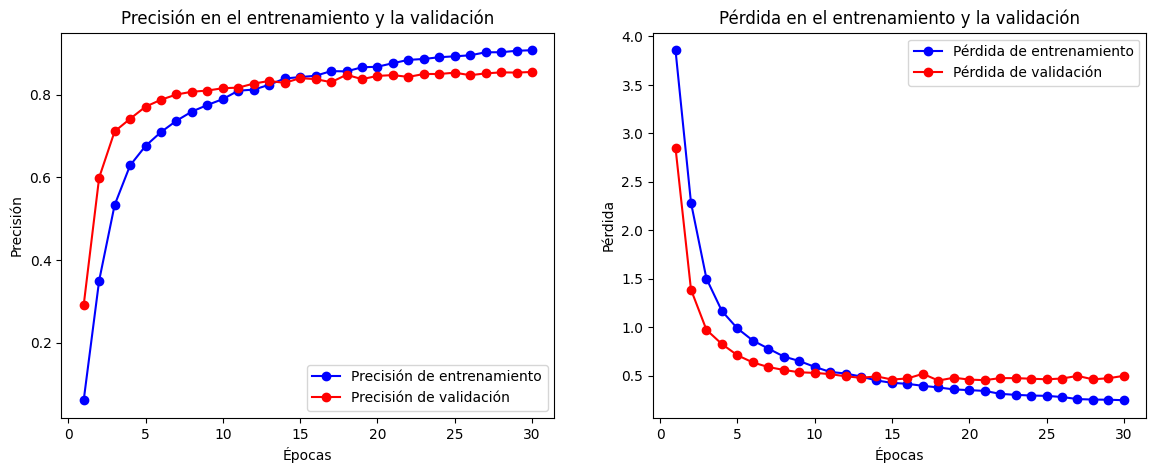

In [ ]:
plot_history(history, 'cnn base model')

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test_cnn)
print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.5474
Precisión en el conjunto de prueba: 83.80%


In [ ]:
with mlflow.start_run():

    mlflow.tensorflow.log_model(model, "cnn base model")

    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_metric("train_accuracy", train_accuracy[-1])
    mlflow.log_metric("val_accuracy", val_accuracy[-1])
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss[-1])
    mlflow.log_metric("val_loss", val_loss[-1])
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_artifact('cnn base model.png')

2024/09/23 04:28:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/09/23 04:28:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


##### II. Buscar mejor modelo

In [ ]:
def objective_cnn(trial):

    num_filters = trial.suggest_int('num_filters', 16, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 7, step=2)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'selu', 'tanh'])
    epochs = trial.suggest_int('epochs', 30, 60)

    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size=(kernel_size, kernel_size), activation=activation, padding='same',
                     input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    for i in range(num_layers - 1):
        num_filters *= 2
        model.add(Conv2D(num_filters, kernel_size=(kernel_size, kernel_size), activation=activation, padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(62, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Añadir callbacks: EarlyStopping y ReduceLROnPlateau
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Entrenar el modelo
    history = model.fit(X_train, y_train_cnn,
                        validation_data=(X_val, y_val_cnn),
                        epochs=epochs,
                        batch_size=32, verbose=0,
                        callbacks=[early_stopping, reduce_lr])

    # Retornar la mejor precisión de validación
    return max(history.history['val_accuracy'])

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_cnn, n_trials=50)

[I 2024-09-16 05:59:46,975] A new study created in memory with name: no-name-b7f2cd13-bb84-4057-875a-c9538a8a7dc3
[I 2024-09-16 06:05:38,117] Trial 0 finished with value: 0.7556207180023193 and parameters: {'num_filters': 125, 'kernel_size': 7, 'num_layers': 2, 'learning_rate': 7.69853688060684e-05, 'dropout_rate': 0.348251486103969, 'activation': 'selu', 'epochs': 52}. Best is trial 0 with value: 0.7556207180023193.
[I 2024-09-16 06:06:48,454] Trial 1 finished with value: 0.5163733959197998 and parameters: {'num_filters': 54, 'kernel_size': 7, 'num_layers': 1, 'learning_rate': 2.3889248362595753e-05, 'dropout_rate': 0.11237361160875442, 'activation': 'tanh', 'epochs': 44}. Best is trial 0 with value: 0.7556207180023193.
[I 2024-09-16 06:09:36,223] Trial 2 finished with value: 0.7971652150154114 and parameters: {'num_filters': 105, 'kernel_size': 3, 'num_layers': 3, 'learning_rate': 2.9436769551574277e-05, 'dropout_rate': 0.46825409817897584, 'activation': 'selu', 'epochs': 39}. Best i

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)
best_trial = study.best_trial

Best hyperparameters: {'num_filters': 47, 'kernel_size': 5, 'num_layers': 4, 'learning_rate': 0.0010538504774863038, 'dropout_rate': 0.3770022049861306, 'activation': 'relu', 'epochs': 47}
Best accuracy: 0.9054251909255981


In [ ]:
num_filters = best_trial.params['num_filters']
kernel_size = best_trial.params['kernel_size']
num_layers = best_trial.params['num_layers']
learning_rate = best_trial.params['learning_rate']
activation = best_trial.params['activation']
dropout_rate = best_trial.params['dropout_rate']
epochs = best_trial.params['epochs']

print('num_filters:', num_filters)
print('kernel_size:', kernel_size)
print('num_layers:', num_layers)
print('learning_rate:', learning_rate)
print('activation:', activation)
print('dropout_rate:', dropout_rate)
print('epochs:', epochs)


num_filters: 47
kernel_size: 5
num_layers: 4
learning_rate: 0.0010538504774863038
activation: relu
dropout_rate: 0.3770022049861306
epochs: 47


In [ ]:
best_cnn = Sequential()
best_cnn.add(Conv2D(num_filters, kernel_size=(kernel_size, kernel_size), activation=activation, padding='same',
                    input_shape=(32, 32, 1)))
best_cnn.add(BatchNormalization())
best_cnn.add(MaxPooling2D(pool_size=(2, 2)))


for i in range(num_layers - 1):
    num_filters *= 2
    best_cnn.add(Conv2D(num_filters, kernel_size=(kernel_size, kernel_size), activation=activation, padding='same'))
    best_cnn.add(BatchNormalization())
    best_cnn.add(MaxPooling2D(pool_size=(2, 2)))

best_cnn.add(Flatten())
best_cnn.add(Dropout(dropout_rate))
best_cnn.add(Dense(62, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
best_cnn.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 47)          │           1,222 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 47)          │             188 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 47)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 94)          │         110,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 94)          │             376 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 94)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 188)           │         441,988 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 188)           │             752 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 188)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 376)           │       1,767,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 376)           │           1,504 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 376)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1504)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1504)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 62)                  │          93,310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,417,460 (9.22 MB)

 Trainable params: 2,416,050 (9.22 MB)

 Non-trainable params: 1,410 (5.51 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = best_cnn.fit(X_train, y_train_cnn,
                        validation_data=(X_val, y_val_cnn),
                        epochs=epochs,
                        batch_size=32, verbose=0,
                       callbacks=[early_stopping, reduce_lr])

In [ ]:
train_accuracy, val_accuracy, train_loss, val_loss = print_history(history)

Pérdida de entrenamiento: 0.008297493681311607
Pérdida de validación: 0.3591232895851135
Precisión de entrenamiento: 0.9988595843315125
Precisión de validación: 0.9037145376205444


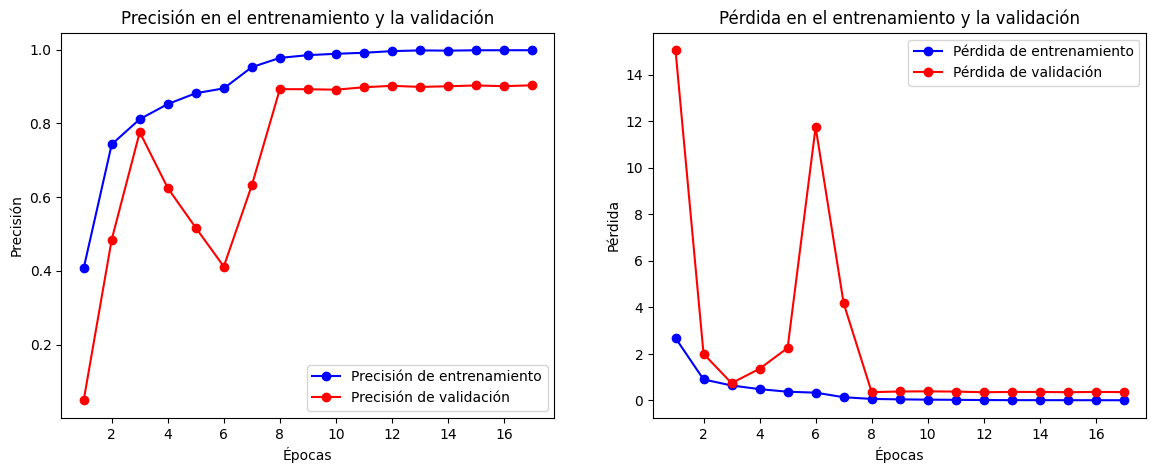

In [ ]:
plot_history(history, 'cnn best model')

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = best_cnn.evaluate(X_test, y_test_cnn)
print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8977 - loss: 0.3702
Precisión en el conjunto de prueba: 89.47%


In [ ]:
with mlflow.start_run():

    mlflow.tensorflow.log_model(best_cnn, "cnn best model")

    mlflow.log_param("num_filters", num_filters)
    mlflow.log_param("kernel_size", kernel_size)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("activation", activation)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", 32)
    mlflow.log_metric("train_accuracy", train_accuracy[-1])
    mlflow.log_metric("val_accuracy", val_accuracy[-1])
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss[-1])
    mlflow.log_metric("val_loss", val_loss[-1])
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_artifact('cnn best model.png')

2024/09/23 04:34:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/09/23 04:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


La pérdida de validación (curva roja) muestra inestabilidad

##### III. Optimizar modelo cnn



In [ ]:
def cnn_model_1(input_shape=(32, 32, 1), num_classes=1):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
cnn = cnn_model_1(input_shape=(32, 32, 1), num_classes=y_train_cnn.shape[1])

In [ ]:
cnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 559,006 (2.13 MB)

 Trainable params: 557,854 (2.13 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
history = cnn.fit(X_train, y_train_cnn,
                        validation_data=(X_val, y_val_cnn),
                        epochs=100,
                        batch_size=32, verbose=0,
                       callbacks=[early_stopping, reduce_lr])

In [ ]:
train_accuracy, val_accuracy, train_loss, val_loss = print_history(history)

Pérdida de entrenamiento: 0.2257300615310669
Pérdida de validación: 0.26509836316108704
Precisión de entrenamiento: 0.9276637434959412
Precisión de validación: 0.9054251909255981


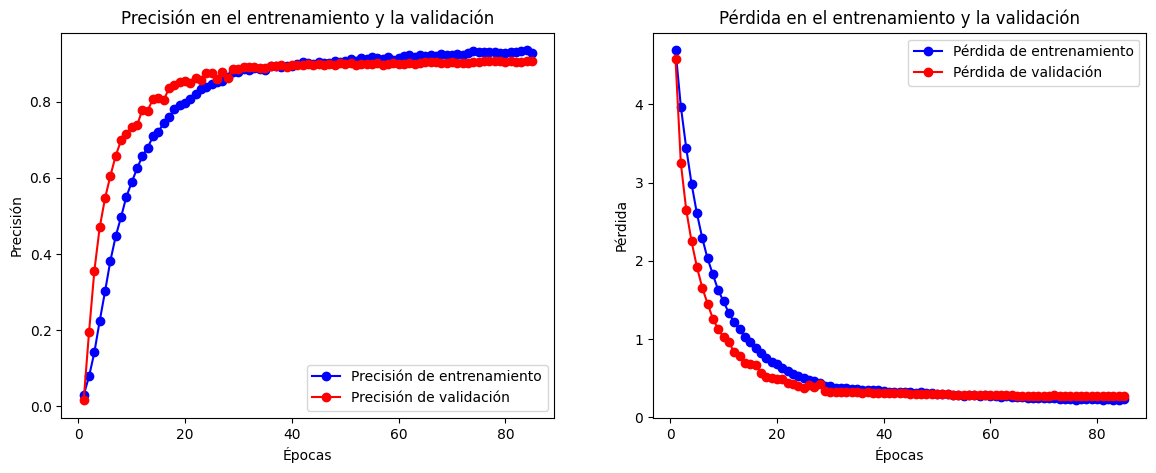

In [ ]:
plot_history(history, 'cnn optimized model')

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = cnn.evaluate(X_test, y_test_cnn)
print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.2972
Precisión en el conjunto de prueba: 89.71%


In [ ]:
with mlflow.start_run():

    mlflow.tensorflow.log_model(cnn, "cnn optimized model")

    mlflow.log_param('learning_rate', 0.0001)
    mlflow.log_param("epochs", 100)
    mlflow.log_param("batch_size", 32)
    mlflow.log_metric("train_accuracy", train_accuracy[-1])
    mlflow.log_metric("val_accuracy", val_accuracy[-1])
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss[-1])
    mlflow.log_metric("val_loss", val_loss[-1])
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_artifact('cnn optimized model.png')

2024/09/23 04:40:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/09/23 04:40:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 3. Comparación de modelos

### 3.0 Configuración

In [13]:
mlflow.set_experiment("handwritten recognition")

<Experiment: artifact_location='file:///content/mlruns/681922117407597071', creation_time=1726089556809, experiment_id='681922117407597071', last_update_time=1726089556809, lifecycle_stage='active', name='handwritten recognition', tags={}>

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [14]:
class Model():

  client = mlflow.tracking.MlflowClient()
  runs = mlflow.search_runs(experiment_ids='681922117407597071')

  def __init__(self, model_name, sk=True):
    self.model_name = model_name
    self.model_id = None
    self.model = None
    self.predictions = None
    self.accuracy = None
    self.report = None
    self.sk = sk
    self.prediction_classes = None
    self.metrics = None
    self.get_model_id()
    self.load_model()
    self.get_metrics()

  @classmethod
  def get_id(cls,model_name):
    filtered_runs = cls.runs[cls.runs['tags.mlflow.log-model.history'].str.contains(model_name)]
    return filtered_runs.iloc[0]['run_id']

  def get_model_id(self):
    try:
      self.model_id = Model.get_id(self.model_name)
    except Exception as e:
      print(f"Error getting the model ID: {e}")

  def load_model(self):
    try:
      model_uri = f"runs:/{self.model_id}/{self.model_name}"
      if self.sk:
        self.model =  mlflow.sklearn.load_model(model_uri)
      else:
        self.model = mlflow.tensorflow.load_model(model_uri)
    except Exception as e:
      print(f"Error loading the model: {e}")

  def predict(self, X):
    try:
      self.predictions = self.model.predict(X)
      if not self.sk:
        self.prediction_classes = np.argmax(self.predictions, axis=1)
    except Exception as e:
      print(f"Error making predictions: {e}")
      return None

  def evaluate(self, y):
    try:
      if self.sk:
        self.accuracy = accuracy_score(y, self.predictions)
        self.report = classification_report(y, self.predictions)
      else:
        self.accuracy = accuracy_score(y, self.prediction_classes)
        self.report = classification_report(y, self.prediction_classes)
    except Exception as e:
      print(f"Error evaluating the model: {e}")
      return None

  def make_report(self, X, y):
    self.predict(X)
    self.evaluate(y)

  def print_report(self):
    print("Model name:", self.model_name)
    print("Model id:", self.model_id)
    print("Accuracy:", self.accuracy)
    print("Classification Report:\n", self.report)

  def get_metrics(self):
    try:
        run = mlflow.get_run(self.model_id)
        self.metrics = run.data.metrics
    except Exception as e:
        print(f"Error getting metrics: {e}")

  def print_metrics(self):
    for metric_name, metric_value in self.metrics.items():
        print(f"{metric_name}: {metric_value}")

### 3.1 SVC

#### I. svc base model

In [15]:
# cargar modelo svc base

svc_base_model = Model("svc base model")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Predicciones en el conjunto de prueba con SVM

svc_base_model.make_report(X_test_flat, y_test)
svc_base_model.print_report()

Model name: svc base model
Model id: 49b2c9521a0a4702b0a3b6737016ffae
Accuracy: 0.4411045943304008
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.29      0.27        66
           1       0.25      0.48      0.33        66
           2       0.52      0.48      0.50        66
           3       0.47      0.45      0.46        66
           4       0.25      0.21      0.23        66
           5       0.57      0.41      0.48        66
           6       0.53      0.39      0.45        66
           7       0.31      0.50      0.38        66
           8       0.29      0.32      0.30        66
           9       0.24      0.44      0.31        66
          10       0.41      0.42      0.42        66
          11       0.41      0.39      0.40        66
          12       0.62      0.70      0.66        66
          13       0.57      0.58      0.57        66
          14       0.72      0.52      0.60        66
          15

#### II. svc best model

In [ ]:
# cargar modelo svc base
svc_best_model = Model("svc best model")

In [ ]:
svc_best_model.make_report(X_test_flat, y_test)
svc_best_model.print_report()

Model name: svc best model
Model id: 6342d3bda48349d49852fdc574f87b5a
Accuracy: 0.5285923753665689
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.33      0.31        66
           1       0.30      0.52      0.38        66
           2       0.59      0.53      0.56        66
           3       0.55      0.52      0.53        66
           4       0.39      0.39      0.39        66
           5       0.56      0.58      0.57        66
           6       0.51      0.52      0.51        66
           7       0.59      0.62      0.60        66
           8       0.38      0.42      0.40        66
           9       0.44      0.53      0.48        66
          10       0.57      0.62      0.59        66
          11       0.44      0.47      0.46        66
          12       0.67      0.73      0.70        66
          13       0.61      0.67      0.64        66
          14       0.67      0.58      0.62        66
          15

### 3.2 Random Forest

#### I. Random forest base model

In [ ]:
rf_base_model = Model("random forest base model")

In [ ]:
rf_base_model.make_report(X_test_flat, y_test)
rf_base_model.print_report()

Model name: random forest base model
Model id: 7f901b6dc44b4142b6c4c5756ac85bc0
Accuracy: 0.4389051808406647
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.29      0.26        66
           1       0.27      0.47      0.34        66
           2       0.48      0.41      0.44        66
           3       0.41      0.48      0.44        66
           4       0.34      0.27      0.30        66
           5       0.60      0.45      0.52        66
           6       0.44      0.41      0.43        66
           7       0.46      0.59      0.52        66
           8       0.30      0.21      0.25        66
           9       0.40      0.44      0.42        66
          10       0.45      0.65      0.53        66
          11       0.42      0.35      0.38        66
          12       0.48      0.76      0.59        66
          13       0.51      0.48      0.50        66
          14       0.60      0.44      0.51        66
  

#### II. Random Forest best model

In [ ]:
rf_best_model = Model("random forest best model")

In [ ]:
rf_best_model.make_report(X_test_flat, y_test)
rf_best_model.print_report()

Model name: random forest best model
Model id: 9f33d477228c4296b512254b98aa3ad1
Accuracy: 0.4389051808406647
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.29      0.26        66
           1       0.27      0.47      0.34        66
           2       0.48      0.41      0.44        66
           3       0.41      0.48      0.44        66
           4       0.34      0.27      0.30        66
           5       0.60      0.45      0.52        66
           6       0.44      0.41      0.43        66
           7       0.46      0.59      0.52        66
           8       0.30      0.21      0.25        66
           9       0.40      0.44      0.42        66
          10       0.45      0.65      0.53        66
          11       0.42      0.35      0.38        66
          12       0.48      0.76      0.59        66
          13       0.51      0.48      0.50        66
          14       0.60      0.44      0.51        66
  

### 3.3 CNN

#### I. cnn base model

In [ ]:
cnn_base_model = Model("cnn base model", sk=False)

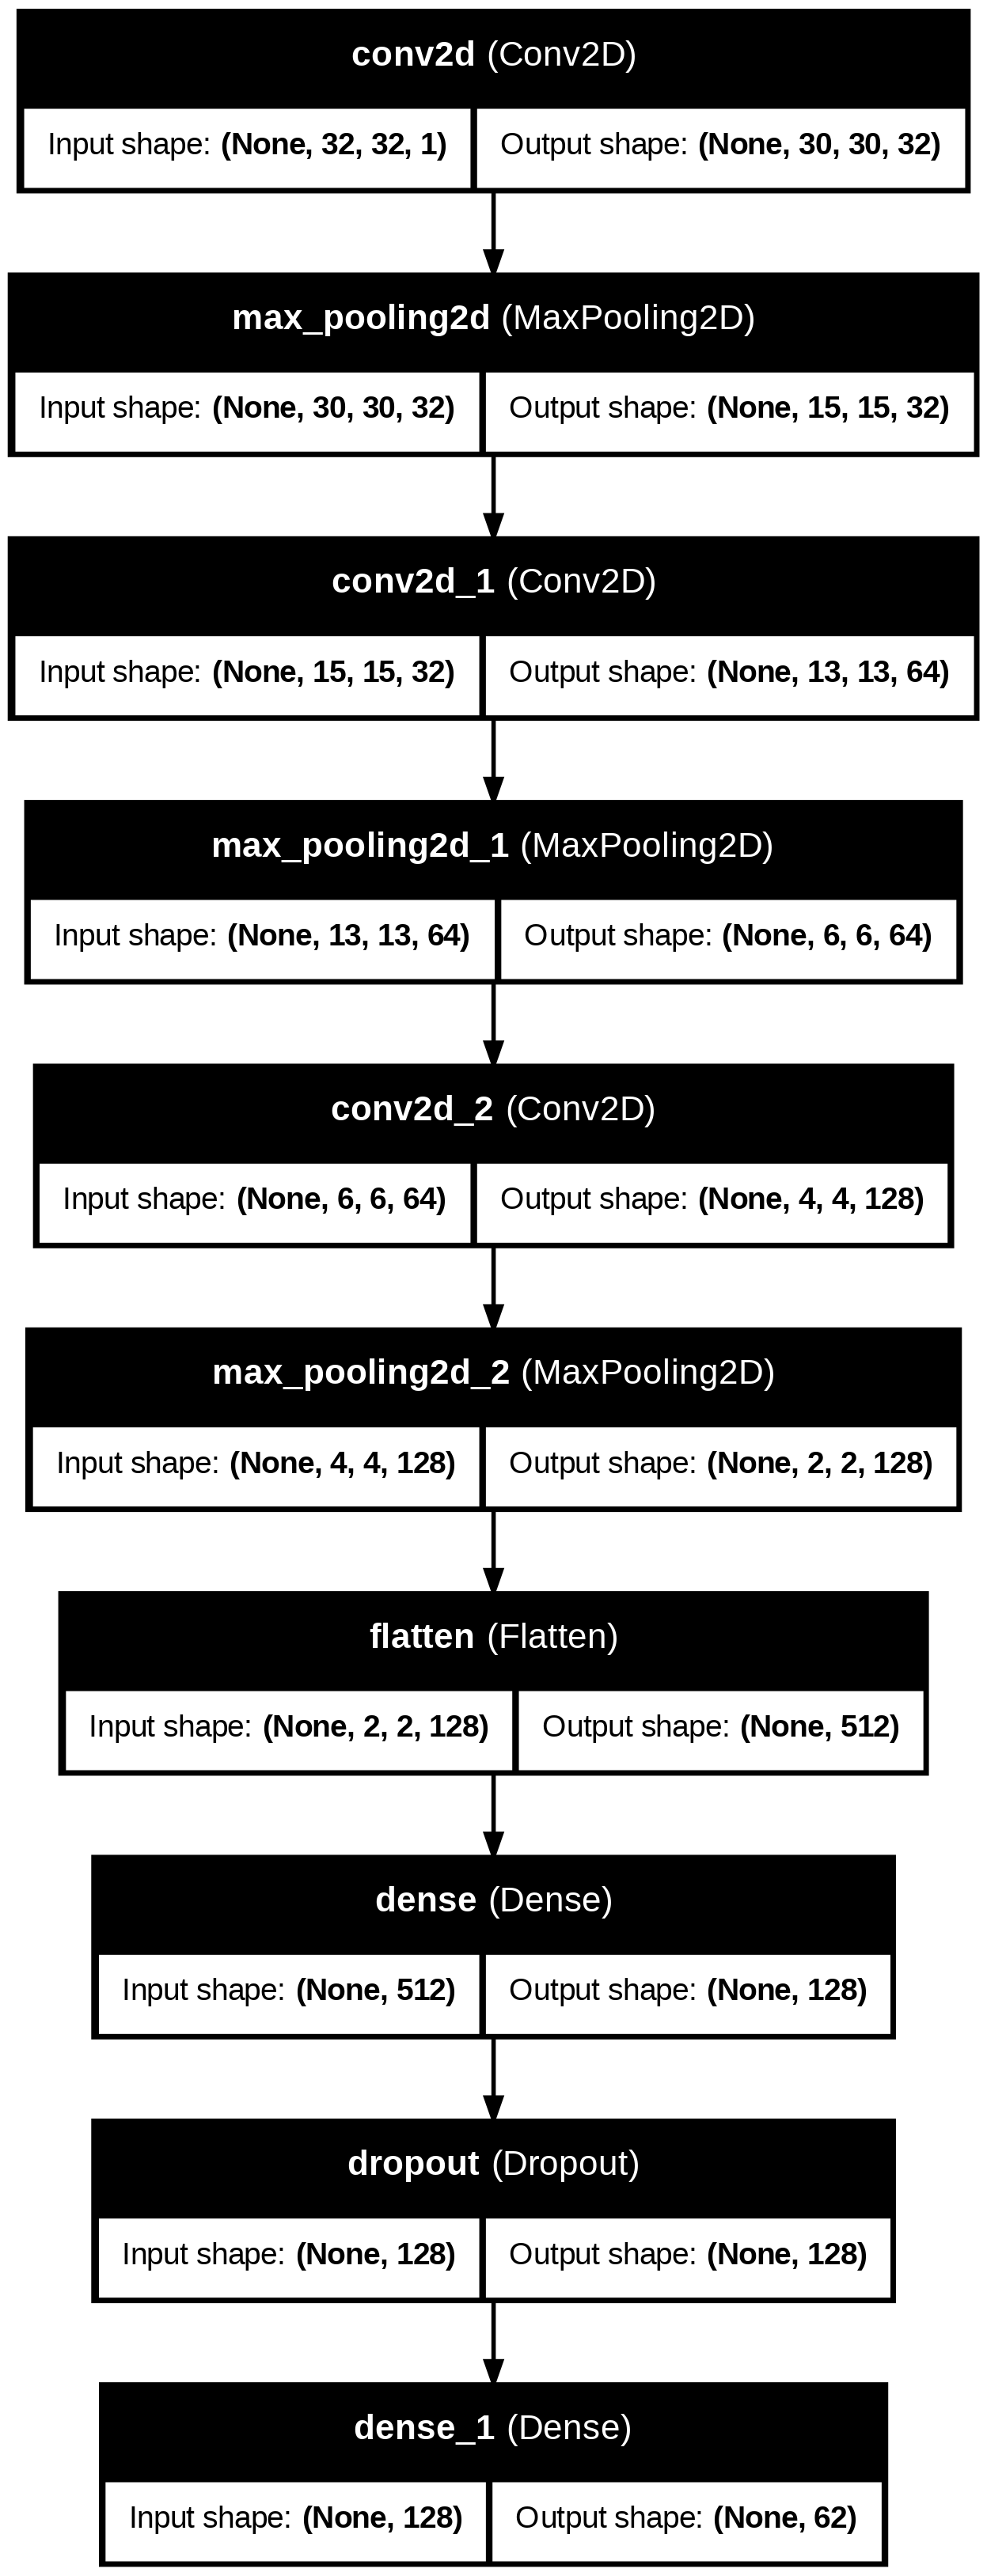

In [ ]:
plot_model(cnn_base_model.model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_base_model.make_report(X_test, y_test)
cnn_base_model.print_report()

128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
Model name: cnn base model
Model id: a3a058a1210a497890bc2ae0f5cf5950
Accuracy: 0.8460410557184751
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.42      0.48        66
           1       0.62      0.64      0.63        66
           2       0.86      0.94      0.90        66
           3       0.84      0.89      0.87        66
           4       0.90      0.91      0.90        66
           5       0.90      0.86      0.88        66
           6       0.91      0.97      0.94        66
           7       0.90      0.92      0.91        66
           8       0.81      0.88      0.84        66
           9       0.78      0.85      0.81        66
          10       0.98      0.94      0.96        66
          11       0.98      0.88      0.93        66
          12       0.73      0.82      0.77        66
          13       0.93      0.97      0.95        66
          14       0.97 

#### II. cnn best model

In [16]:
cnn_best_model = Model("cnn best model", sk=False)

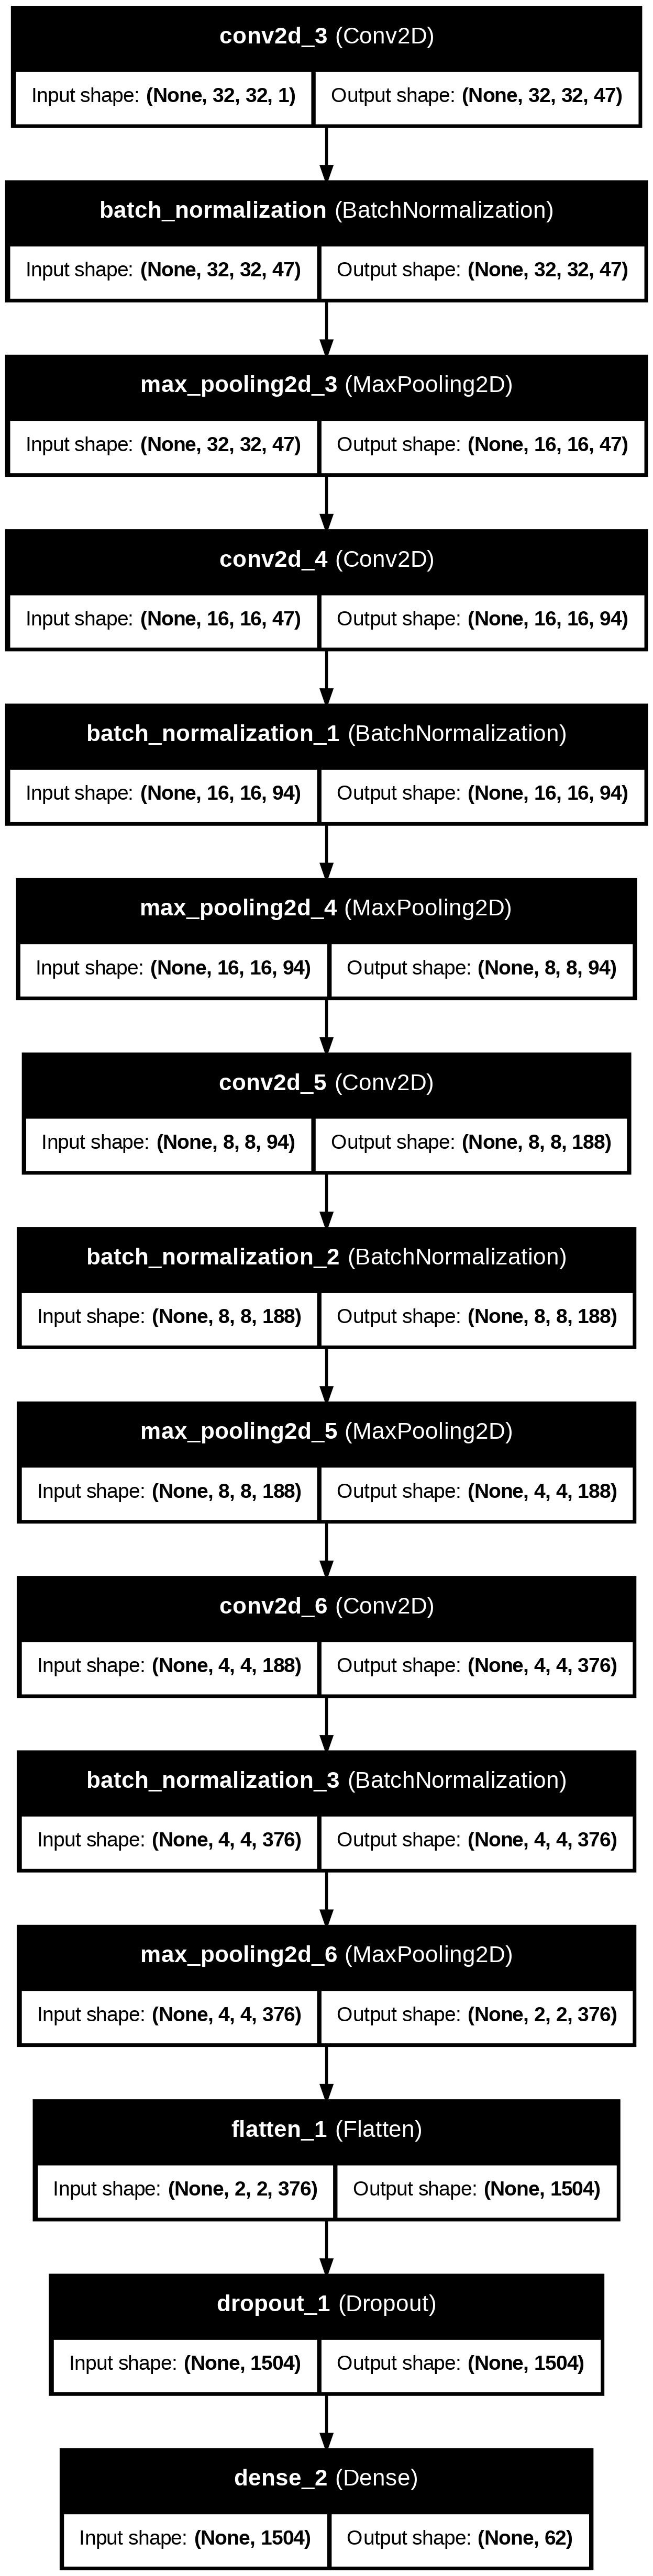

In [17]:
plot_model(cnn_best_model.model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_best_model.make_report(X_test, y_test)
cnn_best_model.print_report()

128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step
Model name: cnn best model
Model id: 7e21e07fc9364a94aad1cdea71c911a6
Accuracy: 0.9012707722385142
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.59      0.56        66
           1       0.69      0.73      0.71        66
           2       0.93      0.94      0.93        66
           3       0.97      0.97      0.97        66
           4       0.98      0.91      0.94        66
           5       0.93      0.98      0.96        66
           6       0.96      0.97      0.96        66
           7       0.97      0.97      0.97        66
           8       0.90      0.94      0.92        66
           9       0.89      0.88      0.89        66
          10       0.97      0.94      0.95        66
          11       0.97      0.94      0.95        66
          12       0.77      0.86      0.81        66
          13       0.98      0.98      0.98        66
          14       0.98 

#### III. cnn optimized model

In [18]:
cnn_optimized_model = Model("cnn optimized model", sk=False)

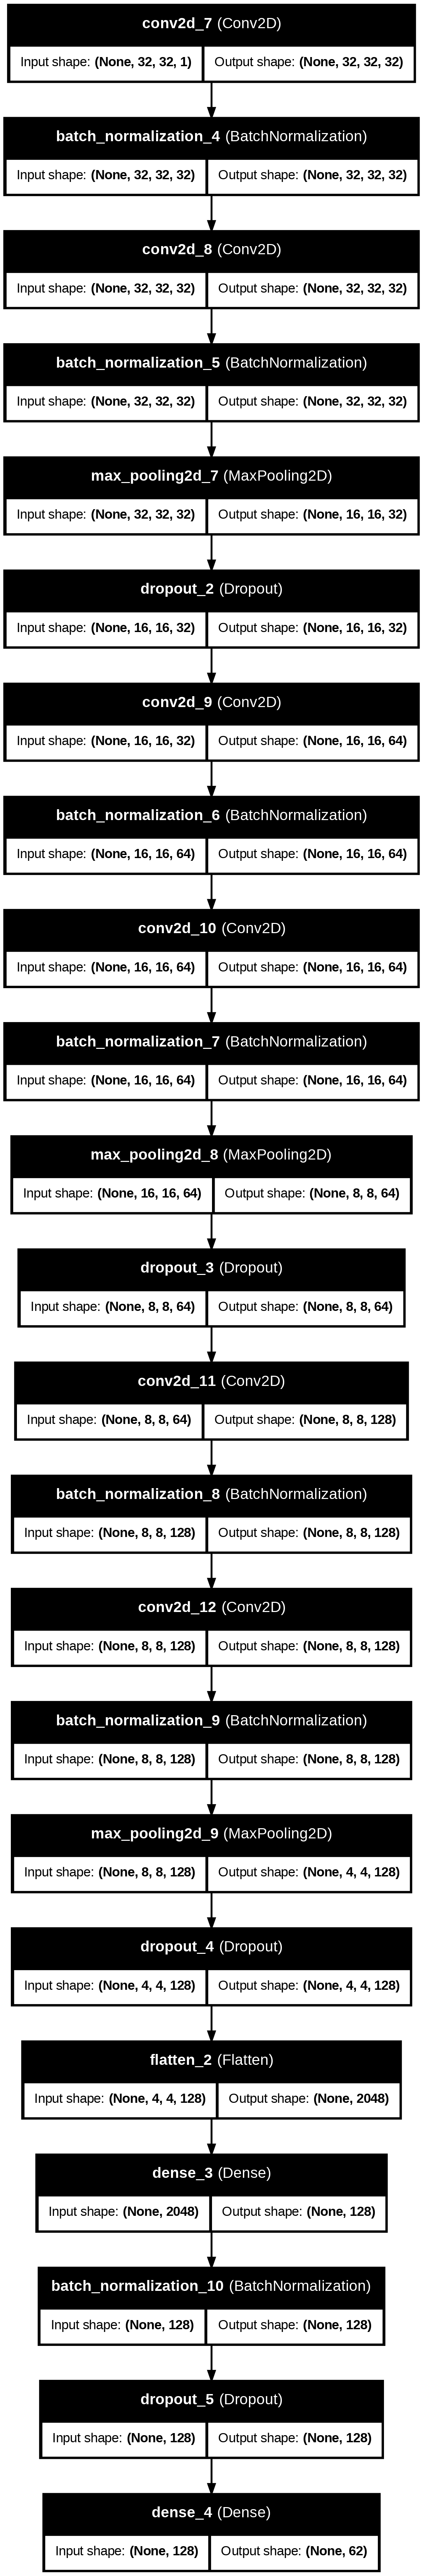

In [19]:
plot_model(cnn_optimized_model.model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_optimized_model.make_report(X_test, y_test)
cnn_optimized_model.print_report()

128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 190ms/step
Model name: cnn optimized model
Model id: 16797b3b457b4a4ba7a0796d2511a7c1
Accuracy: 0.9005376344086021
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.45      0.48        66
           1       0.70      0.74      0.72        66
           2       0.97      0.98      0.98        66
           3       0.95      0.92      0.94        66
           4       1.00      0.92      0.96        66
           5       0.93      0.95      0.94        66
           6       0.94      0.97      0.96        66
           7       0.93      1.00      0.96        66
           8       0.82      0.95      0.88        66
           9       0.93      0.83      0.88        66
          10       0.97      0.95      0.96        66
          11       0.97      0.91      0.94        66
          12       0.76      0.88      0.82        66
          13       0.97      0.97      0.97        66
          14     

### 3.4. Comparación

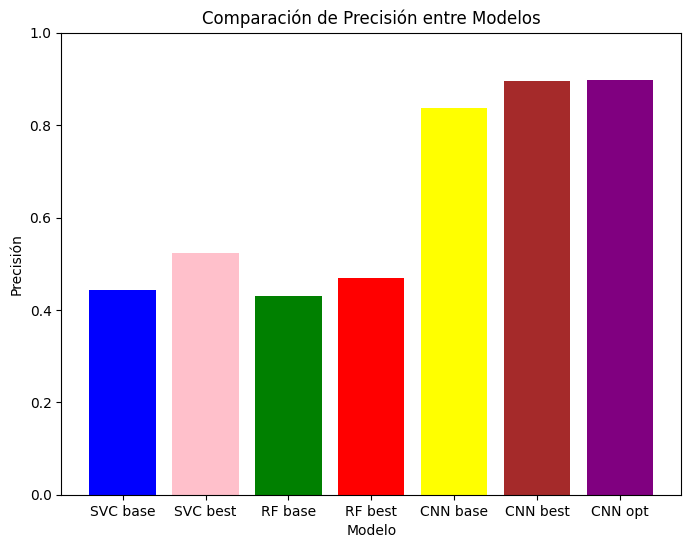

In [ ]:
# Precisión de los modelos
model_names = ['SVC base', 'SVC best', 'RF base', 'RF best',
               'CNN base', 'CNN best', 'CNN opt']

accuracies = [svc_base_model.metrics['test accuracy'], svc_best_model.metrics['test accuracy'],
              rf_base_model.metrics['test accuracy'], rf_best_model.metrics['test accuracy'],
              cnn_base_model.metrics['test_accuracy'], cnn_best_model.metrics['test_accuracy'],
              cnn_optimized_model.metrics['test_accuracy']]

# Graficar la precisión de cada modelo
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'pink', 'green', 'red', 'yellow', 'brown', 'purple'])
plt.title('Comparación de Precisión entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.show()

In [ ]:
# varianza

t_accuracies = [svc_base_model.metrics['train accuracy'], svc_best_model.metrics['train accuracy'],
              rf_base_model.metrics['train accuracy'], rf_best_model.metrics['train accuracy'],
              cnn_base_model.metrics['train_accuracy'], cnn_best_model.metrics['train_accuracy'],
              cnn_optimized_model.metrics['train_accuracy']]


In [ ]:
diff = (np.array(t_accuracies) - np.array(accuracies)) * 100

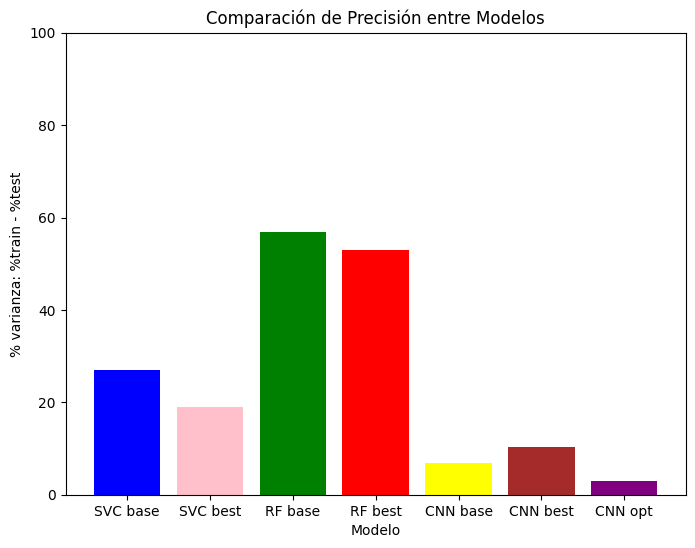

In [ ]:
# Graficar varianza de cada modelo
plt.figure(figsize=(8, 6))
plt.bar(model_names, diff, color=['blue', 'pink', 'green', 'red', 'yellow', 'brown', 'purple'])
plt.title('Comparación de Precisión entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('% varianza: %train - %test')
plt.ylim(0, 100)
plt.show()

A partir de la gráfica que compara la precisión entre diferentes modelos (SVC, Random Forest y CNN) en sus versiones base, optimizadas y mejoradas, podemos hacer las siguientes afirmaciones:

1. **Modelos SVC**:
   - El modelo base de SVC tiene un rendimiento inferior en comparación con su versión optimizada.
   - Después de optimizar el SVC, hay una mejora significativa en la precisión, pero sigue estando por debajo de los modelos basados en CNN.

2. **Modelos Random Forest (RF)**:
   - Tanto el modelo base de Random Forest como su versión optimizada muestran un rendimiento similar, lo que indica que la optimización de RF no tuvo un impacto significativo.
   - Ambos modelos RF tienen una precisión menor en comparación con SVC y CNN, lo que sugiere que RF no es el mejor método para este conjunto de datos en términos de precisión.

3. **Modelos CNN**:
   - El modelo CNN base tiene una precisión significativamente mayor que los modelos SVC y RF, incluso en sus versiones optimizadas.
   - La optimización de la CNN aumenta ligeramente la precisión, lo que sugiere que la arquitectura base ya es fuerte, pero hay margen de mejora con la optimización.
   - El modelo optimizado de CNN tiene una precisión muy cercana a la versión optimizada anterior (CNN best), lo que muestra un rendimiento consistente.

Ala grafica de varianza entre los resultados de entrenamiento y prueba, mostrando cuánto difieren los porcentajes de precisión en estos conjuntos.

1. **Modelos Basados en SVC**:
- El modelo base de SVC tiene una varianza de alrededor del 25%, lo que significa que hay una diferencia considerable entre los resultados en entrenamiento y prueba.

- El modelo mejorado de SVC reduce la varianza a aproximadamente 15%, lo que indica que la optimización ha ayudado a generalizar mejor, aunque aún presenta un nivel notable de varianza.

2. Modelos  Random Forest:
- Los modelos de RF muestran una varianza alta, entre el 60% y el 50%, lo que indica una gran diferencia entre los resultados de entrenamiento y prueba. Esto sugiere un problema de sobreajuste (overfitting), donde el modelo se ajusta demasiado bien a los datos de entrenamiento, pero no generaliza bien en los datos de prueba.

### Modelos CNN:
- Los modelos CNN tienen una varianza muy baja, cercana al 5% para las version optimizada. Esto indica que las CNN generalizan mucho mejor entre los datos de entrenamiento y prueba, y tienen un bajo riesgo de sobreajuste.

- La menor varianza entre los modelos CNN sugiere que son más consistentes y estables en términos de rendimiento.

- Auque CNN best y CNN optimized tienen un accuracy muy parecido, CNN optimized tiene menor varianza, lo que indica una mejor generalización de los datos.

### Conclusión General:
- Las CNN claramente superan tanto a SVC como a RF en términos de precisión, con una varianza mucho menor entre los conjuntos de entrenamiento y prueba, lo que las hace más efectivas y confiables.
- Random Forest, aunque mejorado, muestra un alto nivel de varianza, lo que indica sobreajuste y baja generalización.
- SVC mejora con la optimización, pero sigue siendo inferior en precisión comparado con las CNN.

### Conclusiones:
- **Las redes neuronales convolucionales (CNN)** son claramente superiores en términos de precisión frente a SVC y Random Forest para este problema de reconocimiento de caracteres alfanuméricos, y con una varianza mucho menor entre los conjuntos de entrenamiento y prueba, lo que las hace más efectivas y confiables.
- **SVC** muestra una mejora notable tras la optimización tanto en rendimiento compo en varianza, sin embargo sigue siendo menos precisa que los modelos CNN.

- **Random Forest** tiene el rendimiento más bajo y parece no beneficiarse mucho de la optimización, y muestra un alto nivel de varianza, lo que indica sobreajuste y baja generalización, sugiriendo que este tipo de modelo puede no ser el más adecuado para este tipo de datos o tarea.

- El mejor Modelo encontrado evaluando y comparando los resultados es la red CNN optimizada (CNN optimized).


## 4. Análisis de Errores

In [ ]:
cnn = Model("cnn optimized model", sk=False)

In [ ]:
cnn.predict(X_test)

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [ ]:
def plot_cm(cm):
    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Matriz de Confusión - Análisis de Errores')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

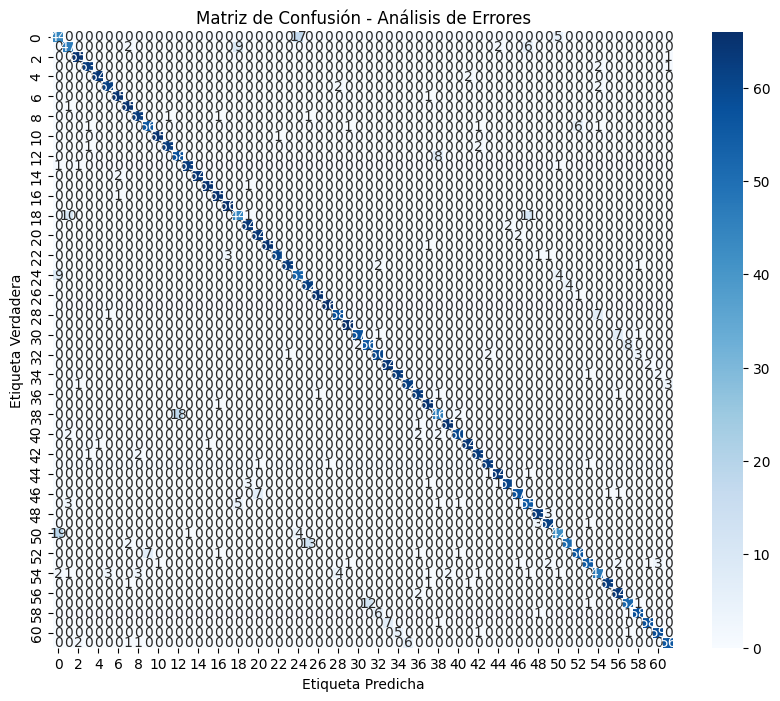

In [ ]:
cm = confusion_matrix(y_test, cnn.prediction_classes)
plot_cm(cm)

In [ ]:
def errors_class(cm):
    # Calcular los errores por clase
    errors_per_class = np.sum(cm, axis=1) - np.diag(cm)

    errors = {}

    # Mostrar las clases con más errores
    for i, error in enumerate(errors_per_class):
        print(f"{i}. Clase {y_dict[i]} tiene {error} errores")
        if error >= 10:
            errors[y_dict[i]] = error

    errors = dict(sorted(errors.items(), key=lambda item: item[1], reverse=True))

    return errors

In [ ]:
errors = errors_class(cm)

0. Clase 0 tiene 29 errores
1. Clase 1 tiene 13 errores
2. Clase 2 tiene 1 errores
3. Clase 3 tiene 1 errores
4. Clase 4 tiene 0 errores
5. Clase 5 tiene 4 errores
6. Clase 6 tiene 0 errores
7. Clase 7 tiene 0 errores
8. Clase 8 tiene 1 errores
9. Clase 9 tiene 6 errores
10. Clase A tiene 1 errores
11. Clase B tiene 2 errores
12. Clase C tiene 6 errores
13. Clase D tiene 0 errores
14. Clase E tiene 0 errores
15. Clase F tiene 0 errores
16. Clase G tiene 1 errores
17. Clase H tiene 0 errores
18. Clase I tiene 13 errores
19. Clase J tiene 1 errores
20. Clase K tiene 4 errores
21. Clase L tiene 1 errores
22. Clase M tiene 2 errores
23. Clase N tiene 0 errores
24. Clase O tiene 13 errores
25. Clase P tiene 8 errores
26. Clase Q tiene 0 errores
27. Clase R tiene 0 errores
28. Clase S tiene 6 errores
29. Clase T tiene 0 errores
30. Clase U tiene 7 errores
31. Clase V tiene 7 errores
32. Clase W tiene 4 errores
33. Clase X tiene 2 errores
34. Clase Y tiene 2 errores
35. Clase Z tiene 4 errore

In [ ]:
# mayor cantidad de errores
for key, value in errors.items():
        print(f"{key}: {value}")

o: 24
0: 22
I: 22
c: 20
1: 19
s: 19
p: 15
v: 14
O: 13
l: 11
r: 11
9: 10
V: 10
q: 10
z: 10


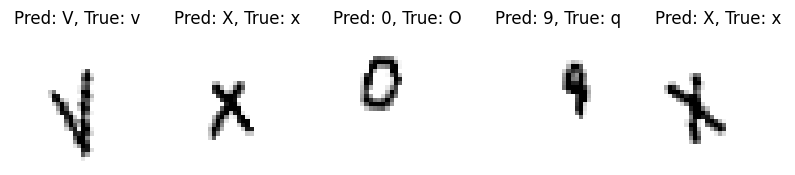

In [ ]:
# Visualizar ejemplos mal clasificados
incorrect_indices = np.where(cnn.prediction_classes != y_test)[0]

# Mostrar algunas imágenes mal clasificadas
num_images = 5
plt.figure(figsize=(10, 10))
for i, incorrect_index in enumerate(incorrect_indices[:num_images]):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_test[incorrect_index].reshape(32, 32), cmap='gray')
    plt.title(f"Pred: {y_dict[cnn.prediction_classes[incorrect_index]]}, True: {y_dict[y_test[incorrect_index]]}")
    plt.axis('off')
plt.show()


In [ ]:
def augment_data2(X, y, y_dict, errors, num_augmented_per_image=2):
    X_augmented = []
    y_augmented = []

    for image, label in zip(X, y):
        if y_dict[label] in errors:
            X_augmented.append(image)
            y_augmented.append(label)

        for _ in range(num_augmented_per_image):
            aug_image = datagen.random_transform(image)
            X_augmented.append(aug_image)
            y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

In [ ]:
X_train, y_train = augment_data(X_train, y_train, num_augmented_per_image=2)

In [ ]:
y_train_cnn = to_categorical(y_train, num_classes=62)
y_val_cnn = to_categorical(y_val, num_classes=62)
y_test_cnn = to_categorical(y_test, num_classes=62)

In [ ]:
def cnn_model_opt(input_shape=(32, 32, 1), num_classes=1):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
cnn = cnn_model_opt(input_shape=(32, 32, 1), num_classes=y_train_cnn.shape[1])

cnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = cnn.fit(X_train, y_train_cnn,
                        validation_data=(X_val, y_val_cnn),
                        epochs=100,
                        batch_size=32, verbose=0,
                       callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
train_accuracy, val_accuracy, train_loss, val_loss = print_history(history)

Pérdida de entrenamiento: 0.16866974532604218
Pérdida de validación: 0.1606927216053009
Precisión de entrenamiento: 0.9401542544364929
Precisión de validación: 0.9349951148033142


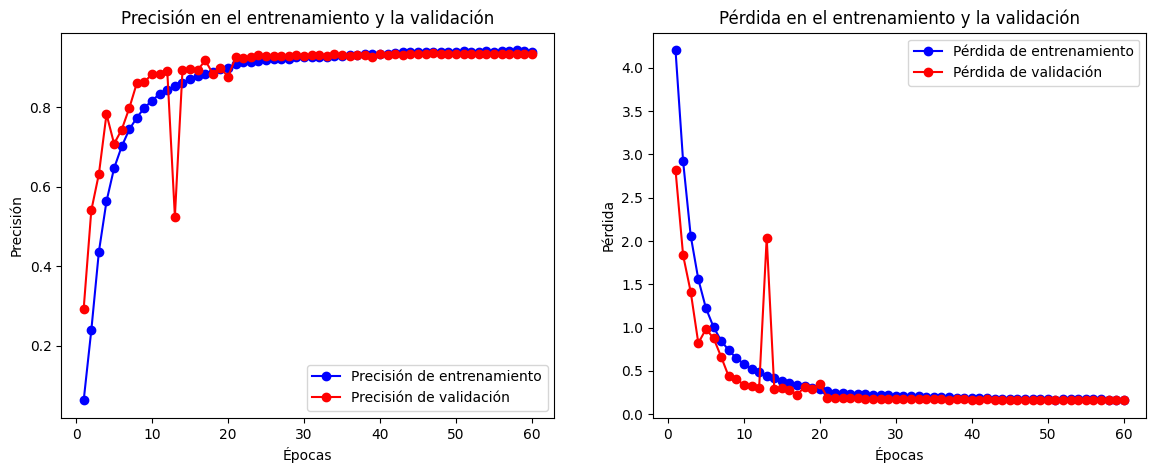

In [ ]:
plot_history(history, 'cnn optimized model')

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = cnn.evaluate(X_test, y_test_cnn)
print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9297 - loss: 0.1801
Precisión en el conjunto de prueba: 93.57%


In [ ]:
predictions = cnn.predict(X_test)
prediction_classes = np.argmax(predictions, axis=1)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


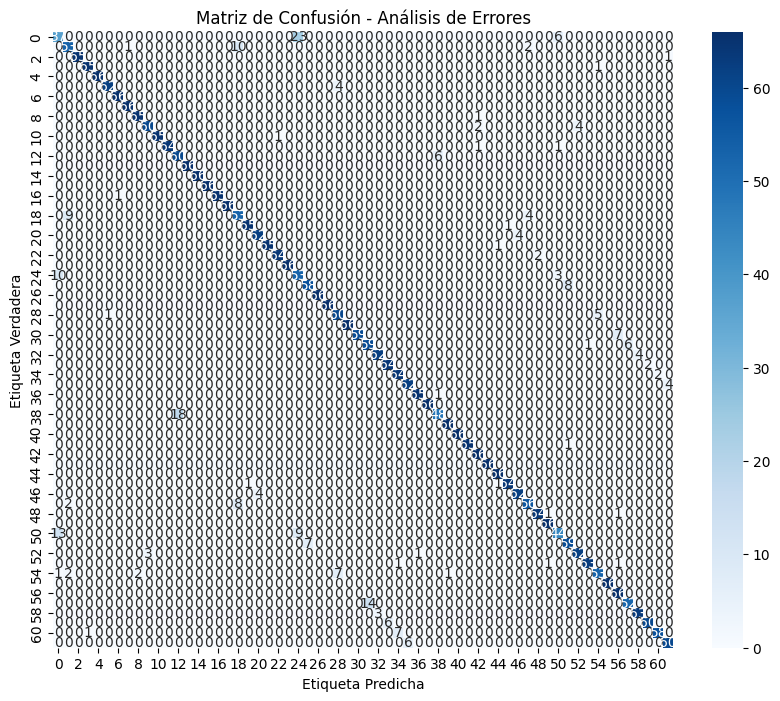

In [ ]:
cm = confusion_matrix(y_test, prediction_classes)
plot_cm(cm)

In [ ]:
errors = errors_class(cm)

Clase 0 tiene 29 errores
Clase 1 tiene 13 errores
Clase 2 tiene 1 errores
Clase 3 tiene 1 errores
Clase 4 tiene 0 errores
Clase 5 tiene 4 errores
Clase 6 tiene 0 errores
Clase 7 tiene 0 errores
Clase 8 tiene 1 errores
Clase 9 tiene 6 errores
Clase A tiene 1 errores
Clase B tiene 2 errores
Clase C tiene 6 errores
Clase D tiene 0 errores
Clase E tiene 0 errores
Clase F tiene 0 errores
Clase G tiene 1 errores
Clase H tiene 0 errores
Clase I tiene 13 errores
Clase J tiene 1 errores
Clase K tiene 4 errores
Clase L tiene 1 errores
Clase M tiene 2 errores
Clase N tiene 0 errores
Clase O tiene 13 errores
Clase P tiene 8 errores
Clase Q tiene 0 errores
Clase R tiene 0 errores
Clase S tiene 6 errores
Clase T tiene 0 errores
Clase U tiene 7 errores
Clase V tiene 7 errores
Clase W tiene 4 errores
Clase X tiene 2 errores
Clase Y tiene 2 errores
Clase Z tiene 4 errores
Clase a tiene 1 errores
Clase b tiene 0 errores
Clase c tiene 18 errores
Clase d tiene 0 errores
Clase e tiene 0 errores
Clase f tie

In [ ]:
for key, value in errors.items():
        print(f"{key}: {value}")

0: 29
o: 22
c: 18
v: 14
1: 13
I: 13
O: 13
s: 13
l: 10


In [ ]:
with mlflow.start_run():

    mlflow.tensorflow.log_model(cnn, "cnn last model")

    mlflow.log_param('learning_rate', 0.0001)
    mlflow.log_param("epochs", 100)
    mlflow.log_param("batch_size", 32)
    mlflow.log_metric("train_accuracy", train_accuracy[-1])
    mlflow.log_metric("val_accuracy", val_accuracy[-1])
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss[-1])
    mlflow.log_metric("val_loss", val_loss[-1])
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_artifact('cnn optimized model.png')

2024/09/24 04:54:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/09/24 04:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Análisis de Errores por Clase:

#### Clases con más errores:
- La **Clase 0** es uan de las que mas errores presenta con **29 errores**, lo cual puede deberse a que es visualmente similar al **o** y **O**.
- La **Clase c** tiene **18 errores**, lo que indica que también sigue siendo un carácter difícil de clasificar correctamente.
- Las **Clases I** y **Clase s** tienen **13 errores** cada una, lo que sugiere que pueden estar siendo confundidas con otros caracteres similares.

#### Clases con menos errores:
- Varias clases no presentan ningún error, como las clases **4, 7, D, E, F, H, N, Q, R, T, h, u**, lo que indica que el modelo tiene un buen desempeño en estas clases.
- También hay algunas clases con **1 o 2 errores**, lo que indica que el modelo está funcionando razonablemente bien en estas clases.

#### Confusión entre caracteres similares:
- **Clase o** y **Clase 0** siguen siendo un caso típico de confusión entre caracteres similares, algo que podría mejorarse con más datos o técnicas avanzadas de aumento de datos para hacer estas clases más distinguibles.
- **Clase I** y **Clase l** presentan confusiones debido a su similitud visual.


## 5. Resumen


###  Introducción

El proyecto aborda el problema de reconocimiento de caracteres alfanuméricos escritos a manos. El objetivo principal es comparar el rendimiento de diferentes modelos de machine learning, incluyendo SVM, Random Forest y Redes Neuronales Convolucionales (CNN), para identificar el modelo más efectivo.


### Descripción del Dataset


El conjunto de datos utilizado proviene de [Kaggle](https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset), que contiene imágenes de caracteres alfanuméricos escritos a mano. Cada imagen está etiquetada con su carácter correspondiente, y el conjunto de datos ha sido dividido en entrenamiento, validación y prueba.

El preprocesamiento de las imágenes incluyó:
- Redimensionamiento de las imágenes a 32x32 píxeles.

- Conversión a escala de grises.

- Normalización de los valores de los píxeles entre 0 y 1.

- aumento de datos de forma aleatoria con rotaciones aleatoria en el rango de +/- 15 grados, zoom aleatorio de hasta +/- 10%, desplazamiento horizontal y vertical de hasta +/- 10%

### Metodología

El flujo de trabajo del proyecto se dividió en las siguientes etapas:

1. **Recolección y preprocesamiento de datos**: Descarga, análisis exploratorio y preparación de los datos.
2. **Modelos Clásicos**: Entrenamiento y evaluación de los modelos SVM y Random Forest.
3. **Red Neuronal Inicial**: Implementación y entrenamiento de una red neuronal inicial.
4. **Red Neuronal Convolucional**: Implementación de una CNN más compleja, optimización de hiperparámetros y evaluación final.
5. **Análisis de Errores**: Identificación de los patrones de error y ajustes basados en los errores detectados.

### Modelos Utilizados


- **SVM (Support Vector Machine)**: Implementado como un modelo base para la clasificación de caracteres. La optimización incluyó el ajuste de hiperparámetros `C`.
- **Random Forest**: Utilizado como segundo modelo clásico. La optimización se realizó ajustando `n_estimators`, `max_depth` `min_samples_split`y `max_features` .
- **CNN (Convolutional Neural Network)**: Este modelo demostró el mejor rendimiento, y fue mejorado con búsqueda de hiperparámetros para ajustar el número de filtros, tamaño del kernel y tasa de aprendizaje y luego se optimizo con el fin de reducir la varianza del modelo.

### Resultados

| Modelo          | Precisión en entrenamiento | Precisión en Validación |
|-----------------|-------------------------|---------------------|
| SVM base        | 71.33%                  | 44.18%              |
| SVM best        | 71.33%                  | 53.81%              |
| RF base         | 100%                    | 43.82%              |
| RF best         | 99.96%                  | 47.95%              |
| CNN base        | 90.77%                  | 85.51%              |
| CNN best        | 99.89%                  | 90.37%              |
| CNN optimized   | 92.77%                  | 90.54%              |

Se escogio el modelo cnn optimized tanto por su rendimiento, como por su poca varianza, ya que generaliza mejor los datos.

### Análisis de Errores



El análisis de errores mostró que el modelo confundía más frecuentemente ciertos caracteres visualmente similares, como "o" "O" y "0", 'I' y "1", "v" y "V", "c" y "C". se aplicó data augmentation para mejorar la robustez del modelo. dando como resultado:

| Modelo| Precisión en Validación | Precisión en Prueba | Precisión en test |
|-------|-------------------------|---------------------|   |
| CNN  last | 94%                  | 93.5%              | 93.57%  |

### Conclusión

La red neuronal convolucional (CNN) fue la que obtuvo el mejor rendimiento en la tarea de reconocimiento de caracteres escritos a mano. El uso de técnicas de optimización y análisis de errores permitió mejorar la precisión y reducir los errores de clasificación.

### X. links


- [mflow](https://drive.google.com/drive/folders/1s75ROSRmUgEDcTvXkc2sVfOTHpBYVPZF?usp=drive_link)
- [github](https://github.com/JulianSalazarD/handwritten)